# MRI Data Synthesizer Python Code - Binary Multi-sphere Phantom 

## *Also Importing Binary Lung Phantom for Testing

### Importing Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

import concurrent.futures
import multiprocessing as mp
from numba import jit, prange # high performance python compiler
import time
import skimage.util
from skimage import measure

import os
parent_dir = os.getcwd()

# universal values:
N = 128 # dimensions of 3D array
I = 1j # defining the imaginary unit 

### Phantom Generation

In [2]:
# function to create a binary sphere in a 3D numpy array
def create_sphere(arr, center, radius):
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            for z in range(arr.shape[2]):
                if (x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2:
                    arr[x, y, z] = 1

# function to check if a new sphere overlaps with existing spheres
def check_overlap(new_center, existing_centers, min_distance):
    for center in existing_centers:
        if np.linalg.norm(np.array(new_center) - np.array(center)) < min_distance:
            return True
    return False

# set seed for reproducible randomness
np.random.seed(203)

# create an NxNxNarray filled with zeros
phantom = np.zeros((N, N, N))

# define the number of spheres and create non-overlapping spheres in the phantom image
num_spheres = 6  # choose 5-6 spheres
sphere_centers = []
min_distance = 10  # minimum distance between sphere centers to avoid overlap

while len(sphere_centers) < num_spheres:
    center = np.random.randint(10, 118, size=3)  # random center coordinates within the image
    radius = np.random.randint(3, 40)  # random radius between 3 and 39
    
    if not check_overlap(center, sphere_centers, min_distance):
        create_sphere(phantom, center, radius)
        sphere_centers.append(center)

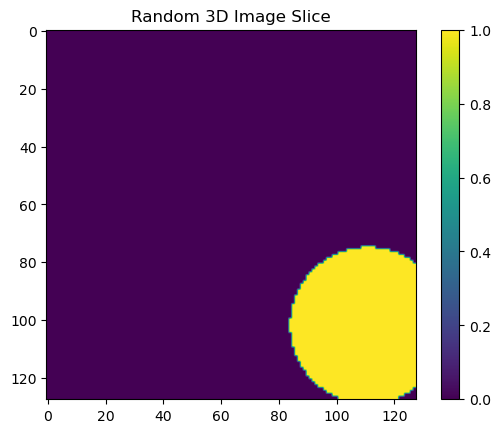

In [3]:
# display a slice of 3D array
slice_idx = N // 2 # central slice in the z direction (since N=128 for all dimensions)
plt.imshow(phantom[:,:,slice_idx]) 

plt.title('Random 3D Image Slice') # 14th slice 
plt.colorbar()
plt.show()

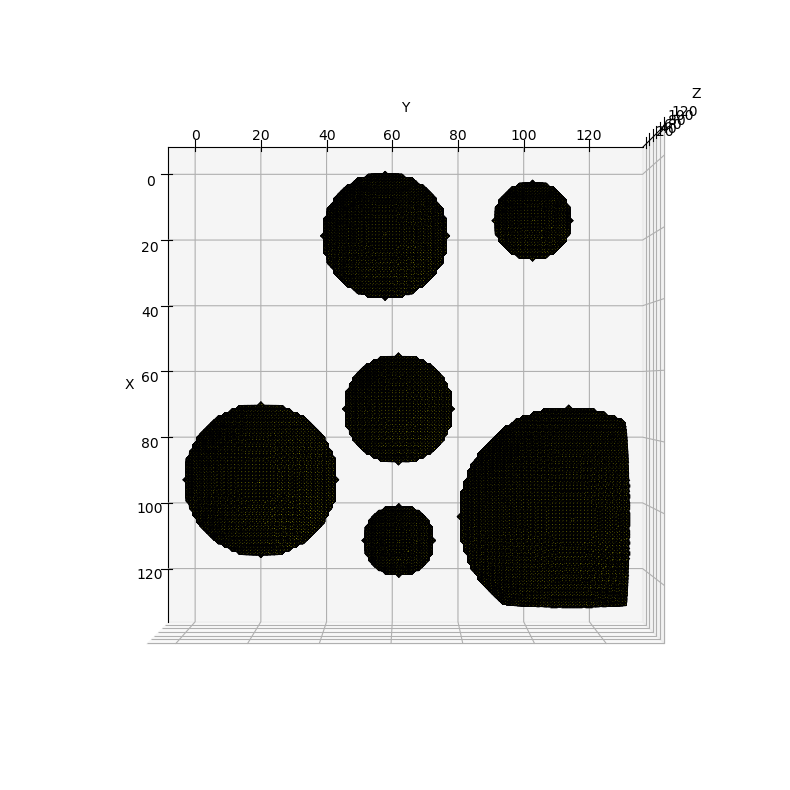

In [5]:
# extract the surface points using marching cubes
verts, faces, _, _ = measure.marching_cubes(phantom, level=0)

# plot the wireframe of the spheres
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], color='yellow', edgecolor='black')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the view to top
ax.view_init(elev=90, azim=0)

plt.show()

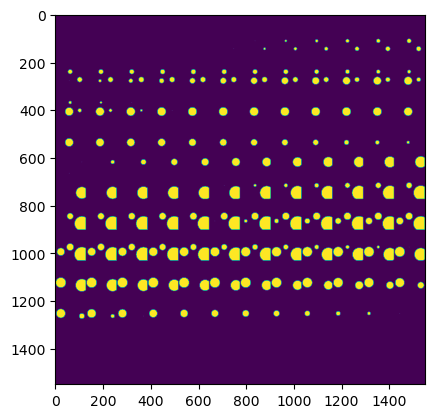

In [5]:
def makeSlide(A):
    ''' displays 3D array as a 2D grayscale image montage'''
    plt.imshow(skimage.util.montage([abs(A[:,:,k]) 
                                     for k in range(0,A.shape[2])], padding_width=1, fill=0))
    plt.show()

makeSlide(phantom)

### Import Binary Lung Phantom

In [6]:
import tkinter as tk
from tkinter import filedialog

root = tk.Tk()
root.withdraw()  # hide the main window
# ask the user to select the file
file_path = filedialog.askopenfilename(title="Select the Phasor/Data File")

lungs = np.load(file_path)

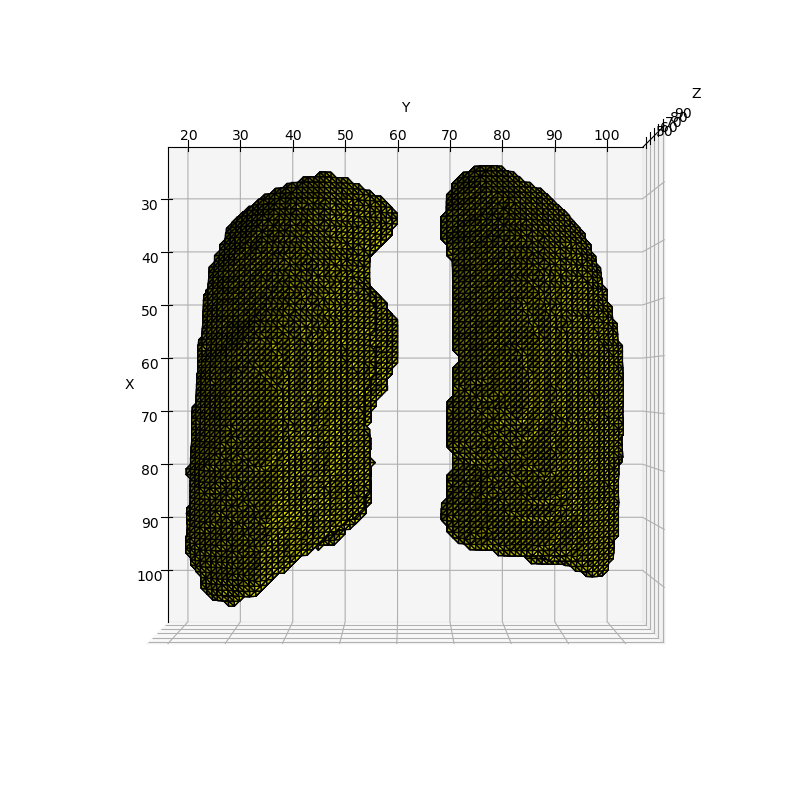

In [7]:
# extract the surface points using marching cubes
verts, faces, _, _ = measure.marching_cubes(lungs, level=0)

# plot the wireframe of the spheres
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], color='yellow', edgecolor='black')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the view to top
ax.view_init(elev=90, azim=0)

plt.show()

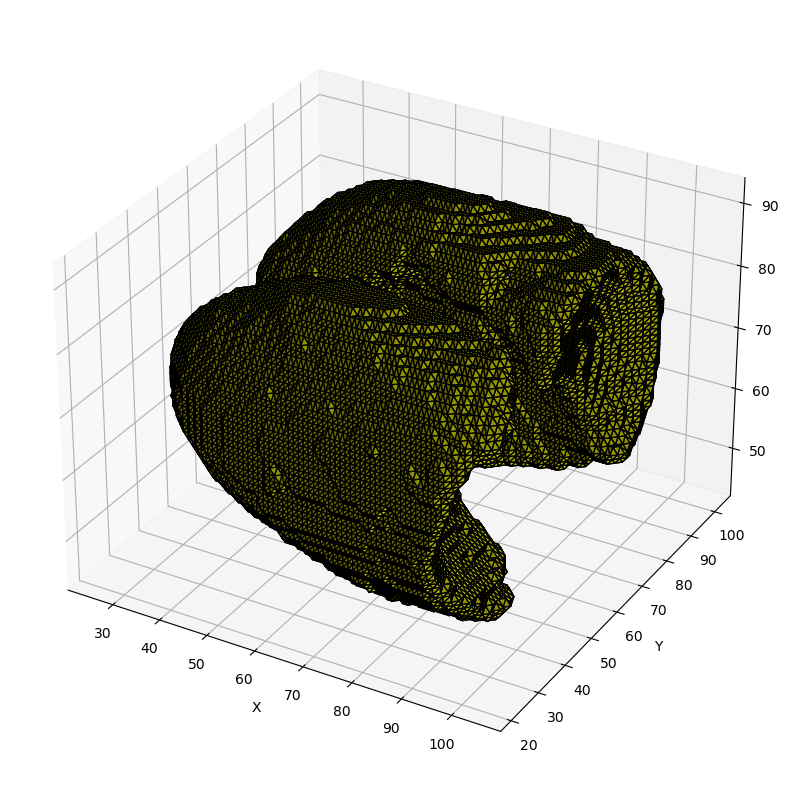

In [8]:
# extract the surface points using marching cubes
verts, faces, _, _ = measure.marching_cubes(lungs, level=0)

# plot the wireframe of the spheres
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], color='yellow', edgecolor='black')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

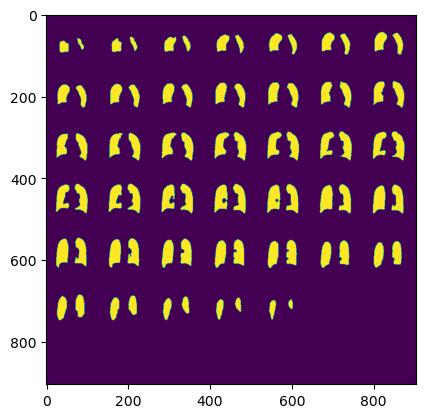

In [122]:
makeSlide(lungs[:,:,50:90])

### Defining Functions

In [9]:
def KSpaceScatterPlot(coordlist, s=5, title='3D Scatter Plot for K-Space Points'):
    '''Create a 3D scatter plot for k-space points
    
    Args: 
        kx - np.ndarray with shape (N, )
        ky - np.ndarray with shape (N, )
        kz - np.ndarray with shape (N, )
        s (scaling factor) - integer or float value (default value of 5)
        title - string of desired plot title (has default value)
    
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coordlist[:,0], coordlist[:,1], coordlist[:,2], s=s)

    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_zlabel('kz')
    ax.set_title(title)

    plt.show()
    
@jit(nopython=True, parallel=True)
def CalculatePhasors(coordlist, array):
    phasors_real = np.zeros(len(coordlist))
    phasors_imag = np.zeros(len(coordlist))
    
    # Counter to track progress
    #count = 0
    
    for i in prange(len(coordlist)):
        x_exp = x * coordlist[i, 0] * 2 * np.pi / N
        y_exp = y * coordlist[i, 1] * 2 * np.pi / N
        z_exp = z * coordlist[i, 2] * 2 * np.pi / N
        
        temp = np.sum(array * np.exp(I * x_exp + I * y_exp + I * z_exp))
        phasors_real[i] = temp.real
        phasors_imag[i] = temp.imag
        
        # Increment the count to track progress
        #count += 1
        
        # Print progress every 'n' iterations
        #if count % 1000 == 0:
            #print(f"Progress: {count}/{len(coordlist)} points")
    
    return phasors_real + 1j * phasors_imag

def PlotPhasors(coordlist, phasors, scale):
    # create arrows for phasors in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # quiver plot to show phasors
    ax.quiver(coordlist[:,0], coordlist[:,1], coordlist[:,2], np.real(phasors)/30, np.imag(phasors)/30, 
                                                        np.zeros_like(phasors), color='red', length=scale)

    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_zlabel('kz')
    ax.set_title('Arrows Representing Phasors in 3D')

    plt.show()
    
@jit(nopython=True, fastmath=True) # speed up math with numba 
def BuildImageFAST(image, phasors, castlist):
    
    for k in range(phasors.shape[0]):
        if ~np.isnan(phasors[k]):
            image = image + phasors[k] * np.exp(-I*x*castlist[k,0]*2*np.pi/N - 
                                                I*y*castlist[k,1]*2*np.pi/N - 
                                                 I*z*castlist[k,2]*2*np.pi/N)
    return image

def BuildImage(phasors, castlist):
    # initialize array
    image = np.zeros_like(x, dtype=complex)
    
    # call fast function which uses numba
    image = BuildImageFAST(image, phasors, castlist)
    
    # rounding and rescaling by a factor of N^3 (to return to 0-1 scale)
    image = np.around(np.divide(image, N**3), decimals=10)
    
    return image

def DisplayImageSlice(image, slice_id=N//2, image_type='modulus'):
    
    # display real component
    if image_type == 'real' or  image_type == 'Real': 
        plt.imshow(np.real(image[:,:,slice_id])) # default is center slice 
        plt.title('Real Component of Image (2D Slice)') 
    # display imaginary component
    elif image_type == 'imag' or  image_type == 'Imag' or image_type == 'imaginary' or image_type == 'Imaginary':
        plt.imshow(np.imag(image[:,:,slice_id]))
        plt.title('Imaginary Component of Image (2D Slice)') # default is center slice 
    else: # display modulus (default)
        plt.imshow(np.abs(image[:,:,slice_id]))
        plt.title('Modulus Component of Image (2D Slice)') # default is center slice 

    plt.colorbar()
    plt.show()
    
def Interp_MultiThread(data, traj, cast):
    # initializing lists 
    complex_phasors = [None] * len(cast) # preallocates memory by specifying length at this step

    Nblocks = 12  # set your desired number of blocks
    total_data_size = cast.shape[0]
    chunk_size = total_data_size // Nblocks  # calculate initial chunk size
    remainder = total_data_size % Nblocks  # calculate remainder for final block

    start = time.perf_counter()
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        index = 0
        
        for k in range(Nblocks):
            # adjust chunk size if remainder exists
            if remainder > 0:
                adjusted_chunk_size = chunk_size + 1
                remainder -= 1
            else:
                adjusted_chunk_size = chunk_size
            
            # calculating the indices for the current chunk
            end_index = index + adjusted_chunk_size
            if end_index > total_data_size:
                end_index = total_data_size
                
            # submitting the griddata function as a task to the executor
            future = executor.submit(griddata, traj, data, cast[index:end_index, :])
            futures.append((future, index, end_index))
            
            index = end_index
        
        # collecting results and assigning them to the correct positions in the final array
        for future, start_idx, end_idx in futures:
            result = future.result()
            complex_phasors[start_idx:end_idx] = result
    
    # convert list of interpolated phasors to numpy array
    complex_data = np.array(complex_phasors)
    
    print(f"Interpolated phasors calculated in {time.perf_counter()-start} seconds")
    
    return complex_data

### Generate perfect Cartesian k-space points, calculate "perfect" phasors, display real/imaginary images 

In [10]:
# creating 3D grids for x, y, and z dimensions
k_axis_vals = np.linspace(-N/2+1, N/2, N)
x, y, z = np.meshgrid(k_axis_vals, k_axis_vals, k_axis_vals)

# flatten 3D grids into 1D arrays
# ravel is faster than flatten, does not occupy memory
kx_0 = x.ravel()
ky_0 = y.ravel()
kz_0 = z.ravel()

cast_list = np.column_stack((kx_0, ky_0, kz_0)) # perfectly cartesian K-space coordinates
coord_list = cast_list

#### *Only run the following code at low N values for sanity checks*

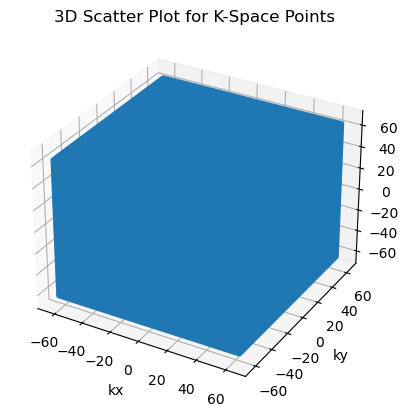

In [8]:
# plot k space coordinates
#KSpaceScatterPlot(coord_list)

Phasors calculated in 5.462348449975252 seconds


/home/labast/miniconda3/envs/DukePipeline/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2615: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:]).astype(float)


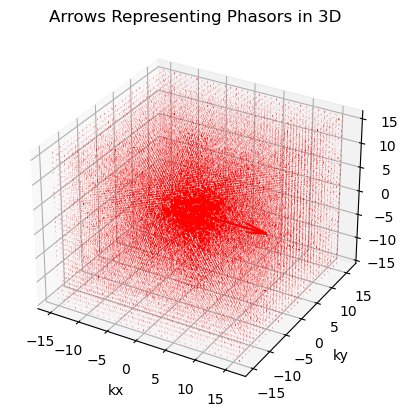

In [10]:
# calculate and plot phasors
# parallel computing
start = time.perf_counter()
perfect_phasors = CalculatePhasors(coord_list, phantom)
end = time.perf_counter()
print(f"Phasors calculated in {end-start} seconds")

PlotPhasors(coord_list, perfect_phasors, scale=0.05)

Image built in 24.916813449002802 seconds


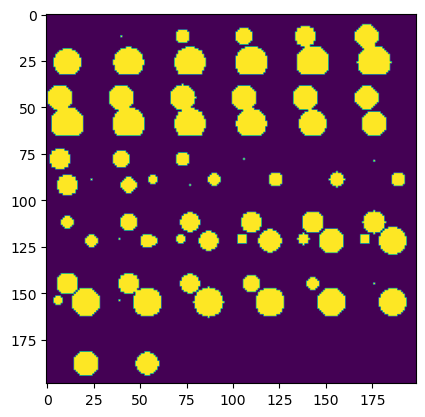

In [14]:
# inverse fourier transform to rebuild image 
start = time.perf_counter()
image = BuildImage(perfect_phasors, coord_list)
end = time.perf_counter()
print(f"Image built in {end-start} seconds")

# displaying all image slices
makeSlide(phantom)

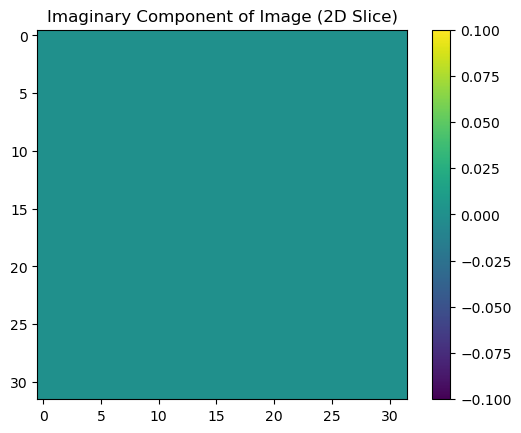

In [15]:
DisplayImageSlice(image, image_type='imag') 

In [16]:
# sanity check - should be the exact same as the original data (maybe a few rounding discrepancies)
np.array_equal(phantom, image)

True

### Linear interpolation using 3D kush ball (radial) k-space trajectory

In [11]:
from scipy.io import loadmat
# go back a directory to load in trajectory
current_dir = os.getcwd()
if current_dir.endswith('DataSynthesizer'):
    os.chdir('..') 
traj = loadmat('traj/traj_gas_afia.mat')

# return to original directory
current_dir = os.getcwd()
if current_dir.endswith('Recon'):
    os.chdir(parent_dir)

# radial trajectory k-space x, y, and z points 
kx = traj['data'][:,:,0].ravel()
ky = traj['data'][:,:,1].ravel()
kz = traj['data'][:,:,2].ravel()

kx = kx*N
ky = ky*N
kz = kz*N

traj_list = np.column_stack((kx, ky, kz))

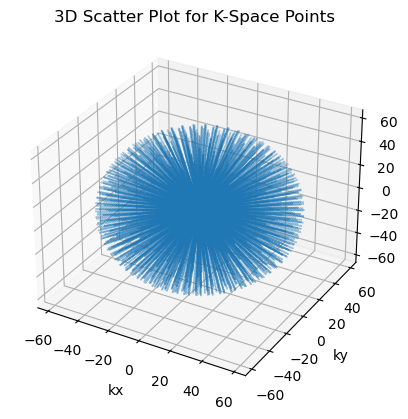

In [12]:
# create 3D scatter plot for kx, ky, kz trajectory points
# create 3D scatter plot
KSpaceScatterPlot(traj_list, s=0.1)

In [13]:
# calculate and plot phasors
# parallel computing
start = time.perf_counter()
radtraj_phasors = CalculatePhasors(traj_list, lungs) # using lung phantom here
end = time.perf_counter()
print(f"Phasors calculated in {end-start} seconds")

Phasors calculated in 586.589035 seconds


/Users/mia/opt/anaconda3/envs/DukePipeline/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2615: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:]).astype(float)


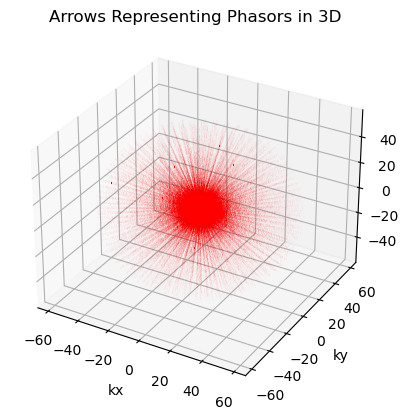

In [14]:
PlotPhasors(traj_list, radtraj_phasors, scale=0.005) 

In [15]:
# preparing cast list
print(cast_list.shape)

# only keep points within trajectory 
# ex. no point in trying to cast to the corners with a radial trajectory
keep = (kx_0**2 + ky_0**2 + kz_0**2) < max(kx)**2
cast_list2 = cast_list[keep,:]
print(cast_list2.shape)

(2097152, 3)
(837817, 3)


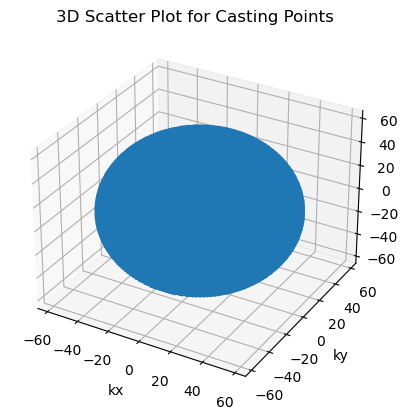

In [16]:
# create 3D scatter plot 
KSpaceScatterPlot(cast_list2, s=0.1, title='3D Scatter Plot for Casting Points')

In [17]:
# interpolating to Cartesian space 
new_radtraj_phasors = Interp_MultiThread(radtraj_phasors, traj_list, cast_list2)

Interpolated phasors calculated in 256.27518495799995 seconds


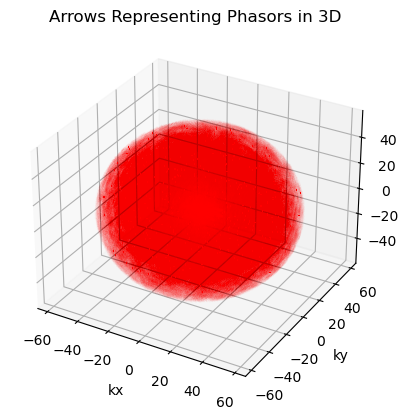

In [18]:
# phasor plot post-interpolation
PlotPhasors(cast_list2, new_radtraj_phasors, scale=0.005)

In [19]:
def quadShift128(A):
    '''swaps the 8 corners of a 128x128x128 3D array (for later FFT)'''
    A = A[np.r_[64:128,0:64], :, :]
    A = A[:,np.r_[64:128,0:64], :]
    A = A[:,:,np.r_[64:128,0:64]]
    return A

def kspaceList_to_ImageArray(traj, data, N=128):
    '''turns Mx3 kSpace coords and M data into an NxNxN image'''
    F = np.zeros((N, N, N),dtype=np.complex_)
    for k in range(len(data)):
        F[int(round(traj[k, 0] + N / 2)), int(round(traj[k, 1] + N / 2)), int(round(traj[k, 2] + N / 2))] = data[k]
    F[~np.isfinite(F)] = 0
    print(F.shape)
    F = quadShift128(F)
    f = np.fft.ifftn(F)
    f = quadShift128(f)
    return f

In [20]:
# convert from k-space to image space 
new_image = kspaceList_to_ImageArray(cast_list2, new_radtraj_phasors)

(128, 128, 128)


In [21]:
# reverse z axis, transpose x and y axes, then horizonal and vertical flip
corrected_image = np.flipud(np.fliplr(np.transpose(new_image[:, :, ::-1], axes=(1, 0, 2))))

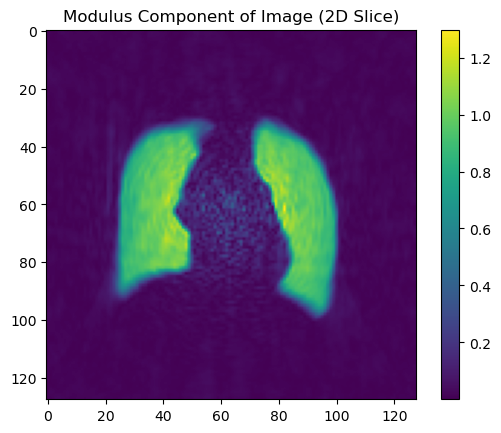

In [22]:
DisplayImageSlice(corrected_image, image_type='modulus') 

In [24]:
def makeSlide(A):
    ''' displays 3D array as a 2D grayscale image montage'''
    plt.imshow(skimage.util.montage([abs(A[:,:,k]) 
                                     for k in range(0,A.shape[2])], padding_width=1, fill=0))
    plt.show()

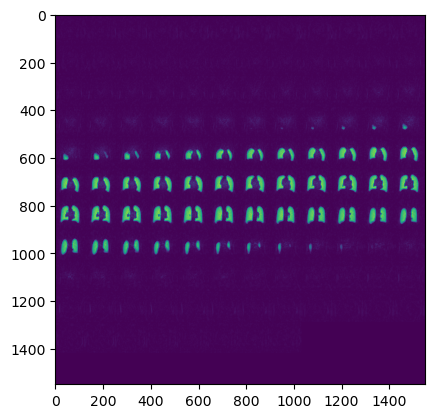

In [25]:
makeSlide(corrected_image)

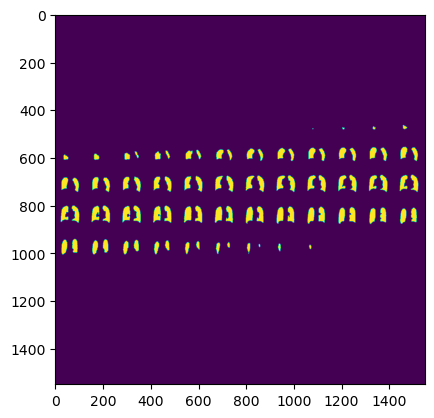

In [26]:
# make sure it matches 
makeSlide(lungs)

### Undersampling K-Space Trajectory 

In [27]:
traj_list.shape

(64000, 3)

In [28]:
# undersample trajectory 
undersampled_trajlist = traj_list[:-8000] 
# reduces the number of points to 56000
undersampled_trajlist.shape

(56000, 3)

In [29]:
undersampled_trajlist1 = undersampled_trajlist[:-8000] 
# reduces the number of points to 48000
undersampled_trajlist1.shape

(48000, 3)

In [30]:
undersampled_trajlist2 = undersampled_trajlist1[:-8000] 
# reduces the number of points to 40000
undersampled_trajlist2.shape

(40000, 3)

In [31]:
undersampled_trajlist3 = undersampled_trajlist2[:-8000] 
# reduces the number of points to 32000
undersampled_trajlist3.shape

(32000, 3)

In [32]:
undersampled_trajlist4 = undersampled_trajlist3[:-16000] 
# reduces the number of points to 16000
undersampled_trajlist4.shape

(16000, 3)

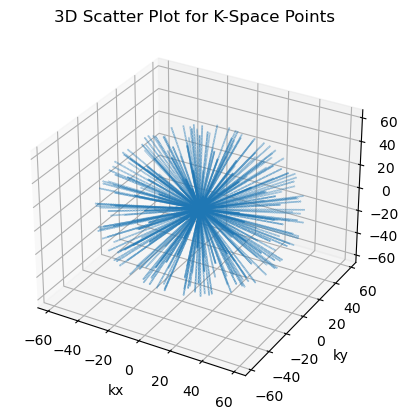

In [33]:
KSpaceScatterPlot(undersampled_trajlist4, s=0.1)

In [34]:
# calculate and plot phasors
# parallel computing
start = time.perf_counter()
radtraj_phasors = CalculatePhasors(undersampled_trajlist4, lungs)
end = time.perf_counter()
print(f"Phasors calculated in {end-start} seconds")

Phasors calculated in 138.796144292 seconds


/Users/mia/opt/anaconda3/envs/DukePipeline/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2615: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:]).astype(float)


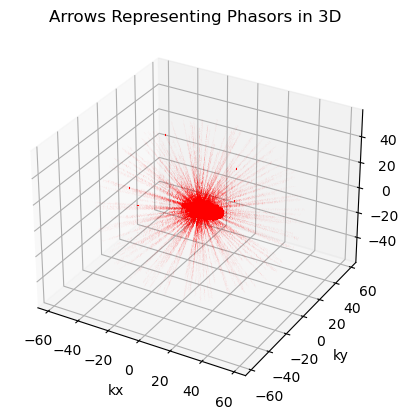

In [35]:
PlotPhasors(undersampled_trajlist4, radtraj_phasors, scale=0.005) 

In [37]:
# save phasors 
#np.save('3D_binary_multisphere_radtraj_undersamp16000_phasors_128', radtraj_phasors)

# load phasors
#radtraj_phasors = np.load('3D_binary_multisphere_radtraj_undersamp16000_phasors_128.npy')

In [38]:
# preparing new cast list
print(cast_list.shape)

# only keep points within trajectory 
# ex. no point in trying to cast to the corners with a radial trajectory
keep = (kx_0**2 + ky_0**2 + kz_0**2) < max(kx)**2
cast_list1 = cast_list[keep,:]
print(cast_list1.shape)

(2097152, 3)
(837817, 3)


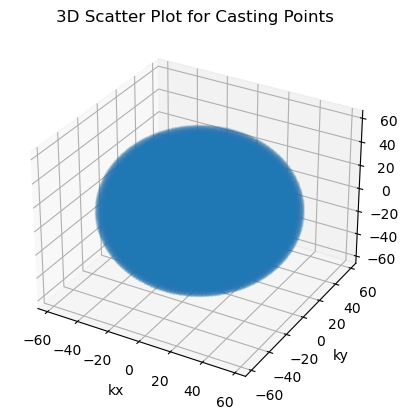

In [39]:
# create 3D scatter plot 
KSpaceScatterPlot(cast_list1, s=0.001, title='3D Scatter Plot for Casting Points')

In [41]:
# interpolate to rectilinear k space
new_radtraj_phasors = Interp_MultiThread(radtraj_phasors, undersampled_trajlist4, cast_list1)

Interpolated phasors calculated in 43.24804204099996 seconds


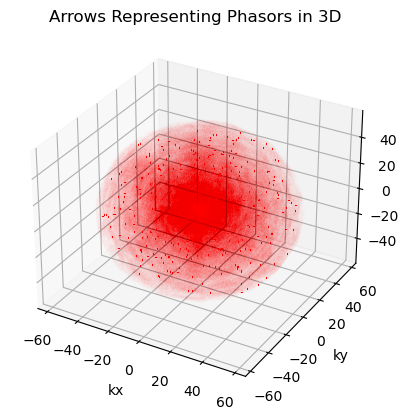

In [42]:
# plot new phasors
PlotPhasors(cast_list1, phasors=new_radtraj_phasors, scale=0.001)

In [43]:
# save 3D phasor data as .npy file 
#np.save('3D_binary_multisphere_radtraj_interpolatedphasors_128.npy', new_radtraj_phasors)

# load in phasors 
#new_radtraj_phasors = np.load('3D_binary_multisphere_radtraj_interpolatedphasors_128.npy')

In [44]:
# convert from k-space to image space 
new_image = kspaceList_to_ImageArray(cast_list2, new_radtraj_phasors)

(128, 128, 128)


In [45]:
# reverse z axis, transpose x and y axes, then horizonal and vertical flip
corrected_image = np.flipud(np.fliplr(np.transpose(new_image[:, :, ::-1], axes=(1, 0, 2))))

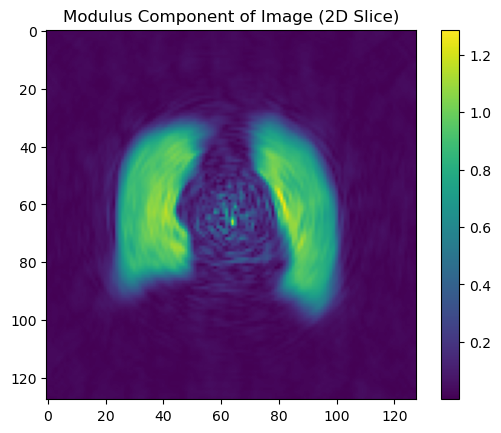

In [46]:
DisplayImageSlice(corrected_image, image_type='modulus') 

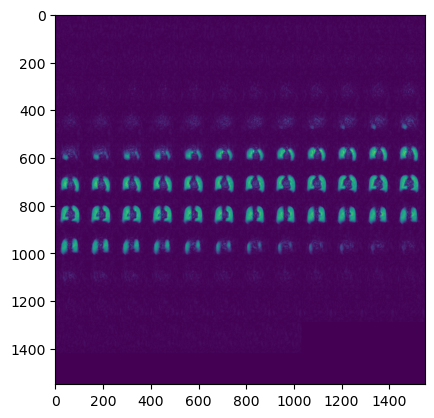

In [47]:
makeSlide(corrected_image)

#### Old & Slow Image Building Code...

In [48]:
# how many nan values?
#non_nan_count = np.count_nonzero(~np.isnan(new_radtraj_phasors))
#nan_count = np.count_nonzero(np.isnan(new_radtraj_phasors))

#print('Non-NAN Values: ' + str(non_nan_count))
#print('NAN Values: ' + str(nan_count))

#nan_count/len(new_radtraj_phasors)*100 # percentage of nan values 

In [49]:
# removing nan indices (does not always work in BuildImage function with numba integration)
#cast_list1.shape
#keep = np.isfinite(new_radtraj_phasors)
#new_radtraj_phasors = new_radtraj_phasors[keep]
#cast_list2 = cast_list1[keep,:]

In [50]:
# inverse fourier transform to rebuild image 
#start = time.perf_counter()
#image2 = BuildImage(new_radtraj_phasors, cast_list2)
#end = time.perf_counter()
#print(f"Image built in {end-start} seconds")

In [51]:
#np.save('3D_binary_multisphere_radtraj_undersamp16000_postinterpolated_image_128.npy', image2)

In [52]:
# displaying all image slices
#makeSlide(image2)

### Comparison of Original Phantom to Interpolated Image

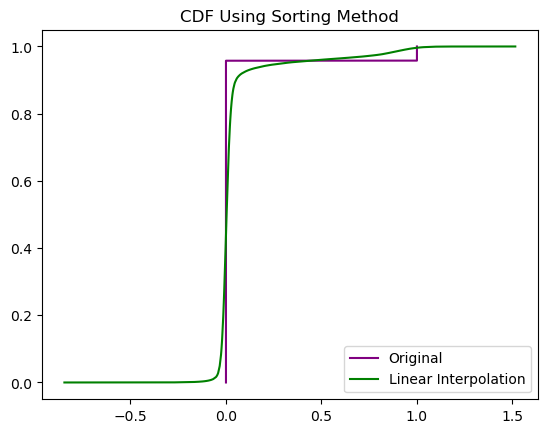

In [54]:
# Looking at Cumulative Distribution Function (CDF)
# Perfect data 
x_0 = np.sort(lungs.ravel())
y_0 = np.arange(len(lungs.ravel())) / float(len(lungs.ravel()))

# Direct linear interpolation with radial trajectory 
x_1 = np.sort(corrected_image.ravel())
y_1 = np.arange(len(corrected_image.ravel())) / float(len(corrected_image.ravel()))

plt.title('CDF Using Sorting Method')

plt.plot(x_0, y_0, color='purple', label='Original')
plt.plot(x_1, y_1, color='green', label='Linear Interpolation')

plt.legend()